In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests 

%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Анализ результатов АБ-теста

В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

## Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

In [3]:
df = pd.read_csv('ab_browser_test.csv')
df.head(5)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


## Задания
### Сравнение кликов в двух группах
Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control __в процентах__ от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [5]:
df_control = df[df.slot == 'control']
df_exp = df[df.slot == 'exp']

In [6]:
n_clicks_control_sum = df_control.n_clicks.sum()
n_clicks_exp_sum  = df_exp.n_clicks.sum()

In [7]:
result = (n_clicks_exp_sum - n_clicks_control_sum) / n_clicks_control_sum * 100
print(np.round(result,3))

1.614


### Бутстреп
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
def get_bootstrap_interval(data, function, alpha = 0.05):
    np.random.seed(0)
    scores = list(map(function, get_bootstrap_samples(data, 1000)))
    return stat_intervals(scores, alpha)

In [11]:
def print_bootstrap_diff_interval(text, exp, control, function, alpha = 0.05):
    n_clicks_interval = get_bootstrap_interval(exp, function, alpha) - get_bootstrap_interval(control, function, alpha)
    print (text, n_clicks_interval)

In [12]:
n_clicks_control_values = df_control.n_clicks.values
n_clicks_exp_values = df_exp.n_clicks.values

In [13]:
print_bootstrap_diff_interval('Интервал среднего разности двух выборок',n_clicks_exp_values,
                         n_clicks_control_values,np.mean)
print_bootstrap_diff_interval('Интервал медианы разности двух выборок',n_clicks_exp_values,
                         n_clicks_control_values,np.median)

Интервал среднего разности двух выборок [0.3004329  0.30201631]
Интервал медианы разности двух выборок [1. 1.]


- 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо

- 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

### Утверждения
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 
- Всё неверно

### Q-Q графики немного ку-ку
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X}−μ}{\frac{S^2}{n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- $\bar{X}$ — среднее значение в выборке — было распределено нормально $N(μ,\frac{σ^2}{n})$
- $\frac{n}{σ^2}S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы $χ^2(n−1) $

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды 
```python    
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
```

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:
```python 
np.random.seed(0)
n_boot_samples = 500
```

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

__Почему мы проверяем именно такие условия?__

В исходной постановке t-критерий требует нормальности распределения $X_i$. Именно из-за этого предположения мы имеем, что $∑X_i∼N(nμ,nσ^2)$ в силу линейности матожидания, независимости всех $X_i$ между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n}∑X_i−μ ∼ N(0,\frac{σ^2}{n})$

Заметим теперь, что следующие распределения эквивалентны $N(0,\frac{σ^2}{n})∼\sqrt{\frac{σ^2}{n}}N(0,1)$

То есть другими словами мы получили, что исходная статистика $\frac{\bar{X}−μ}{\sqrt{\frac{S^2}{n}}}$ распределена как $\frac{N(0,1)}{\frac{S^2n}{n σ^2}} ∼ \frac{N(0,1)}{\frac{S^2}{σ^2}}$

Вспомним, что распределение Стьюдента с $n-1$ степенями свободы определяется как $\frac{N(0,1)}{\sqrt{\frac{χ^2}{(n−1)}}}$. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно $X_i$ были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [14]:
np.random.seed(0)
n_boot_samples = 500

In [15]:
samples = get_bootstrap_samples(n_clicks_control_values, n_boot_samples)

In [16]:
means = samples.mean(axis = 1)

In [17]:
control_boot_chi_squared = []
for i in np.arange(means.shape[0]):
    control_boot_chi_squared.append(np.sum((samples[i] - means[i])**2))

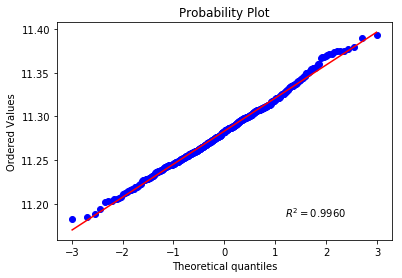

In [18]:
stats.probplot(means, dist="norm", plot=pylab, rvalue = True)
pylab.show()

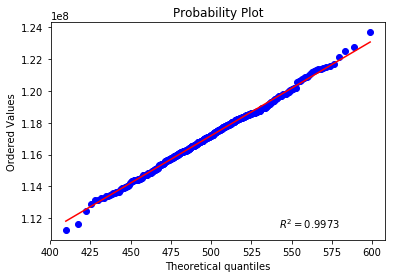

In [19]:
n = len(control_boot_chi_squared)
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt, rvalue = True)
pylab.show()

### Тест Манна-Уитни
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости?

In [20]:
stats.mannwhitneyu(df_exp.n_clicks, df_control.n_clicks)

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

### У моего браузера больше кликов, чем у твоего
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [21]:
df_bro = pd.DataFrame(df.browser.unique(), columns = ['browser'])
df_bro = df_bro.set_index('browser')
df_bro['p'] = 0.
for bro in df_bro.index:    
    df_control_bro = df_control[df_control.browser == bro]
    df_exp_bro = df_exp[df_exp.browser == bro]
    pvalue = stats.mannwhitneyu(df_control_bro.n_clicks, df_exp_bro.n_clicks).pvalue
    df_bro.loc[[bro], ['p']] = pvalue

In [22]:
reject, p_corrected, a1, a2 = multipletests(df_bro.p, 
                                            alpha = 0.05, 
                                            method = 'holm') 

df_bro['p_corrected'] = p_corrected
df_bro['reject'] = reject

In [23]:
df_bro

,p,p_corrected,reject
browser,,,
Browser #2,0.027244,0.136219,False
Browser #4,0.407606,0.815212,False
Browser #14,0.000000,0.000000,True
Browser #17,0.037401,0.149602,False
Browser #20,0.453667,0.815212,False
Browser #22,0.257406,0.772217,False


Статистически значимое отличие есть лишь у браузера 14 - для остальных браузеров медианы их выборок почти одинаковы.

### Нет кликов
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [24]:
df_bro = pd.DataFrame(df.browser.unique(), columns = ['browser'])
df_bro = df_bro.set_index('browser')
df_bro['control_ratio'] = 0.
df_bro['exp_ratio'] = 0.
for bro in df_bro.index:    
    df_control_bro = df_control[df_control.browser == bro]
    df_exp_bro = df_exp[df_exp.browser == bro]
    df_bro.loc[[bro], ['control_ratio']] = 100 * df_control_bro.n_nonclk_queries.sum() / df_control_bro.n_queries.sum()
    df_bro.loc[[bro], ['exp_ratio']] = 100 * df_exp_bro.n_nonclk_queries.sum() / df_exp_bro.n_queries.sum()

In [25]:
df_bro

,control_ratio,exp_ratio
browser,,
Browser #2,45.962747,44.982747
Browser #4,46.970930,45.142942
Browser #14,57.590411,43.755617
Browser #17,36.299367,36.937413
Browser #20,40.540485,38.977376
Browser #22,40.593977,39.853947


Самое большое отличие между контрольной и экспериментальной группами наблюдается у браузера 14 - как и показал критеррий Манна-Уитни с поправкой Холма-Бонферрони.

## Вывод
Был закреплен материал из лекций. Особенно тот факт, что t-критерий накладывает требование на распределение генеральной совокупности и необходимо проверять эти требования с помощью Q-Q графика.Таким образом, более универсальным является критерий Манна-Уитни, который не накладывает никаких требований.